In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sqlite3, pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

# Connect to SQLite database
DB_PATH = "/content/drive/MyDrive/is5126/data/reviews_sample.db"
conn = sqlite3.connect(DB_PATH)

print(f"Connected to {DB_PATH}")


Connected to /content/drive/MyDrive/is5126/data/reviews_sample.db


In [ ]:
# Quick check: available tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print("Available tables:")
print(tables)

Available tables:
              name
0  sqlite_sequence
1          authors
2           hotels
3          reviews


In [ ]:
overview = pd.read_sql("""
SELECT
  COUNT(*) AS n_reviews,
  COUNT(DISTINCT offering_id) AS n_hotels,
  COUNT(DISTINCT CASE WHEN author_id IS NOT NULL AND author_id<>'' THEN author_id END) AS n_authors,
  MIN(review_date) AS min_date,
  MAX(review_date) AS max_date
FROM reviews;
""", conn)

nulls = pd.read_sql("""
SELECT
  AVG(overall IS NULL) AS overall_null_rate,
  AVG(text IS NULL) AS text_null_rate,
  AVG(review_date IS NULL) AS review_date_null_rate,
  AVG(author_id IS NULL OR author_id='') AS author_id_null_rate
FROM reviews;
""", conn)

overview, nulls


(   n_reviews  n_hotels  n_authors             min_date             max_date
 0     754798      3888     522888  2007-12-20 00:00:00  2012-12-20 00:00:00,
    overall_null_rate  text_null_rate  review_date_null_rate  \
 0               0.00            0.00                   0.00   
 
    author_id_null_rate  
 0                 0.06  )


# Extract Base Features with SQL

*   Monthly-level features capturing review volume and average ratings over time
*   Hotel-level features summarizing review counts, average overall and aspect ratings, and rating variability for benchmarking purposes
* Author-level features (using author_id) to analyze reviewer behavior and contribution patterns
* A sampled review-level dataset to support text-related exploratory analysis without incurring excessive memory overhead.

These SQL-extracted feature tables will then load into pandas for visualization and interpretation, forming the foundation for subsequent EDA, benchmarking, and dashboard development.

In [ ]:
monthly = pd.read_sql("""
SELECT
  strftime('%Y-%m', review_date) AS ym,
  COUNT(*) AS review_cnt,
  AVG(overall) AS avg_overall,
  AVG(service) AS avg_service,
  AVG(cleanliness) AS avg_cleanliness,
  AVG(value) AS avg_value,
  AVG(location_rating) AS avg_location
FROM reviews
WHERE review_date IS NOT NULL AND overall BETWEEN 1 AND 5
GROUP BY ym
ORDER BY ym;
""", conn)

monthly["ym"] = pd.to_datetime(monthly["ym"] + "-01")
monthly.head()


,ym,review_cnt,avg_overall,avg_service,avg_cleanliness,avg_value,avg_location
0,2007-12-01,1353,3.75,3.89,4.02,3.78,4.29
1,2008-01-01,4492,3.79,3.92,4.03,3.79,4.32
2,2008-02-01,3533,3.76,3.92,4.05,3.76,4.25
3,2008-03-01,4635,3.76,3.91,4.06,3.75,4.21
4,2008-04-01,5107,3.75,3.91,4.04,3.72,4.25


In [ ]:
hotel_stats = pd.read_sql("""
SELECT
  offering_id,
  COUNT(*) AS n_reviews,
  AVG(overall) AS avg_overall,
  AVG(service) AS avg_service,
  AVG(cleanliness) AS avg_cleanliness,
  AVG(value) AS avg_value,
  AVG(location_rating) AS avg_location,
  (AVG(overall*overall) - AVG(overall)*AVG(overall)) AS var_overall
FROM reviews
WHERE overall BETWEEN 1 AND 5
GROUP BY offering_id;
""", conn)
# >= 50 reviews is a stability threshold. It filters out hotels whose average rating is statistically unreliable because they have too few reviews.
stable_hotels = hotel_stats[hotel_stats["n_reviews"] >= 50].copy()
stable_hotels.head()


,offering_id,n_reviews,avg_overall,avg_service,avg_cleanliness,avg_value,avg_location,var_overall
0,72572,384,4.39,4.56,4.64,4.31,4.53,0.75
1,72579,198,3.69,4.08,4.15,3.97,4.11,1.20
2,72586,237,3.81,4.07,4.07,3.92,4.40,1.14
3,72598,61,2.98,3.30,3.24,3.14,3.11,1.82
7,73445,123,4.72,4.82,4.81,4.77,4.56,0.35


In [ ]:
author_stats = pd.read_sql("""
SELECT
  author_id,
  COUNT(*) AS n_reviews,
  AVG(overall) AS avg_overall
FROM reviews
WHERE author_id IS NOT NULL AND author_id <> '' AND overall BETWEEN 1 AND 5
GROUP BY author_id
HAVING COUNT(*) >= 2;
""", conn)
author_stats.head()

,author_id,n_reviews,avg_overall
0,000024378950A8F32FF775F8E4E8773E,8,4.25
1,0000559F6AD805457FB777DFEA0A00A3,3,3.67
2,00007BA5EAA91850D2B6225CACF69189,3,4.67
3,0000B7B1499D2B2B24AA190405AF56D3,2,3.00
4,0000F3FE498261DFA9A4364F9BE9FCE4,5,4.00


In [ ]:
review_sample = pd.read_sql("""
SELECT overall, service, cleanliness, value, location_rating, sleep_quality, rooms,
       title, text, review_date, via_mobile
FROM reviews
WHERE text IS NOT NULL AND overall BETWEEN 1 AND 5 AND review_date IS NOT NULL
ORDER BY RANDOM()
LIMIT 50000;
""", conn)

review_sample["len_words"] = review_sample["text"].str.split().str.len()
review_sample["review_date"] = pd.to_datetime(review_sample["review_date"])
review_sample.head()


,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,via_mobile,len_words
0,4.00,2.00,5.00,5.00,3.00,5.00,4.00,“Stunning transformation from former Embassy S...,This is the only Conrad Hotel in NYC and was o...,2012-11-29,0,336
1,3.00,NaN,NaN,NaN,NaN,NaN,NaN,“It's ok...”,"Pros: good sized room, big flat screen TV with...",2011-03-17,0,177
2,5.00,5.00,5.00,4.00,4.00,NaN,5.00,“True Service”,I stay with Kimpton as often as possible. The ...,2012-09-24,1,38
3,4.00,4.00,2.00,4.00,NaN,5.00,NaN,“Muy recomendable”,Hemos ido tres personas y nos hemos alojado en...,2011-07-22,0,167
4,5.00,5.00,5.00,5.00,5.00,NaN,5.00,“GREAT AIRPORT LOCATION”,I stayed here for three nights on business. Th...,2012-02-08,1,50


In [ ]:
print("\nMonthly rows:", len(monthly))
print("Hotel rows:", len(stable_hotels))
print("Author rows:", len(author_stats))
print("Review sample rows:", len(review_sample))


Monthly rows: 61
Hotel rows: 2168
Author rows: 103704
Review sample rows: 50000


# Time series EDA (from monthly)


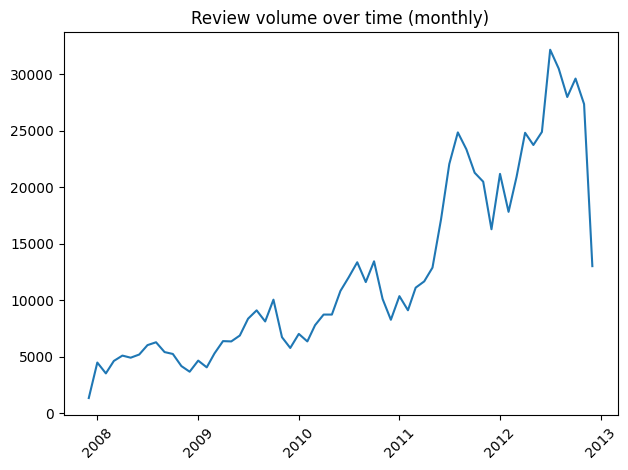

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(monthly["ym"], monthly["review_cnt"])
plt.title("Review volume over time (monthly)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Monthly review volume increases sharply from 2008 to 2012, indicating rapid growth in platform usage and/or hotel coverage. While there are mild month-to-month fluctuations that suggest seasonality, the dominant pattern is a strong upward trend. The sharp drop at the end of the series is likely due to an incomplete final month rather than a true decline.

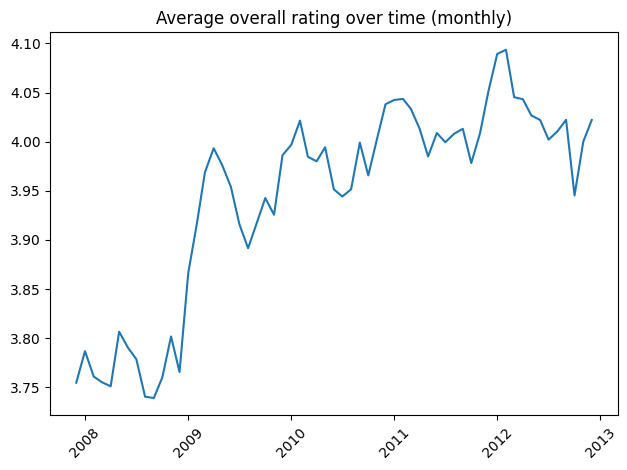

In [ ]:
plt.figure()
plt.plot(monthly["ym"], monthly["avg_overall"])
plt.title("Average overall rating over time (monthly)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Average overall ratings rise from approximately 3.75 in 2008 to around 4.0 and above after 2010, after which they remain relatively stable. This upward shift suggests improving guest satisfaction, changes in hotel mix, or evolving reviewer behavior. Short-term fluctuations persist, but no sustained decline is observed.

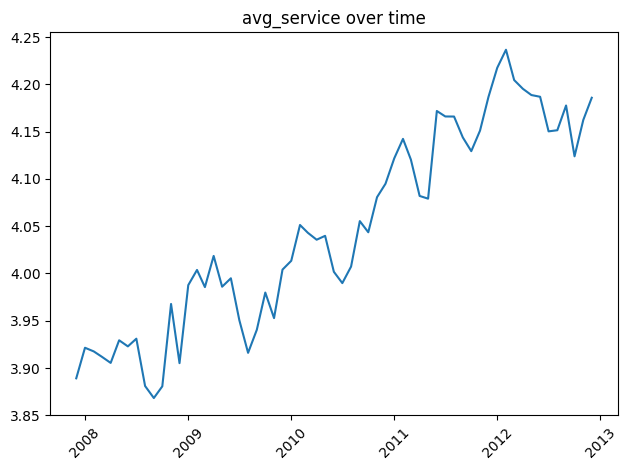

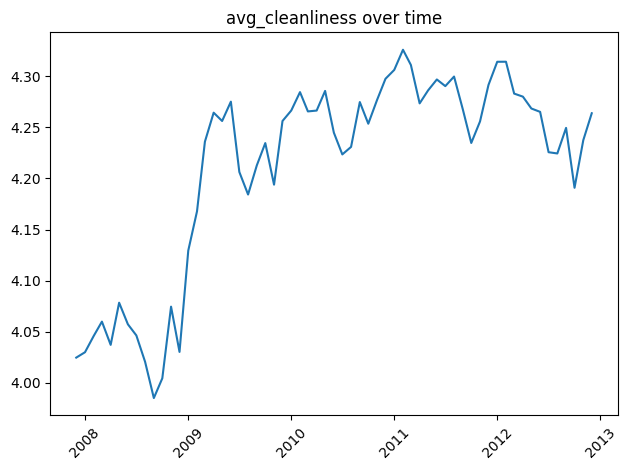

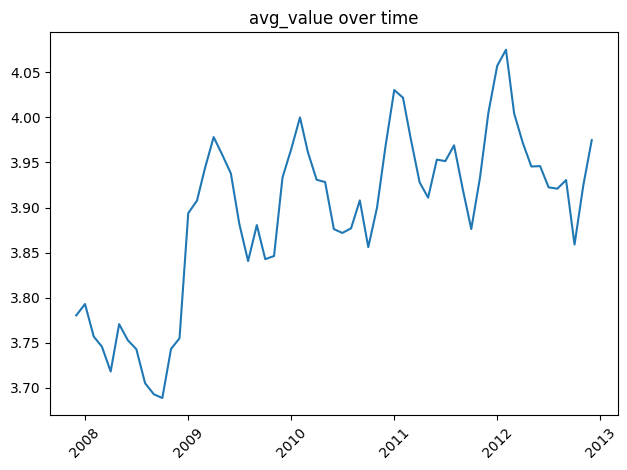

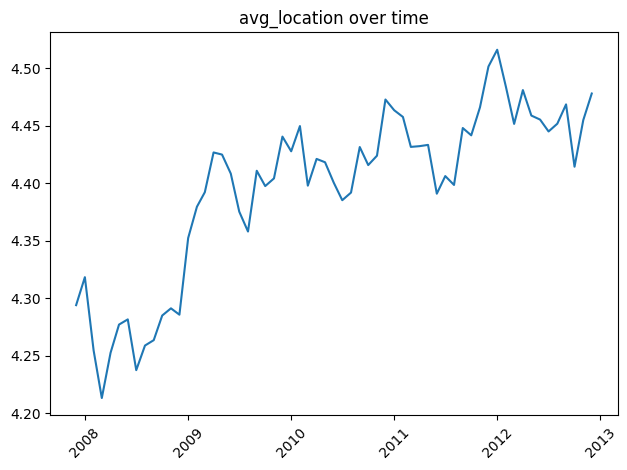

In [ ]:
for col in ["avg_service","avg_cleanliness","avg_value","avg_location"]:
    plt.figure()
    plt.plot(monthly["ym"], monthly[col])
    plt.title(f"{col} over time")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


* Location is consistently the highest-rated aspect with low volatility, indicating it is a stable strength across hotels and largely unaffected by temporal factors.

* Service and cleanliness show steady upward trends over time, suggesting gradual improvements in operational quality that contribute positively to overall guest satisfaction.

* Value exhibits the greatest volatility, with noticeable cyclical fluctuations, implying higher sensitivity to pricing, seasonality, and changing customer expectations.

* Periods of higher value and service ratings tend to align with higher overall satisfaction, highlighting these aspects as key levers for improving guest experience.

### Overall observations

> The observed growth in review volume and upward shift in ratings highlight the importance of time-aware analysis in subsequent stages. As a result, hotel benchmarking and dashboard views will incorporate **period filtering and minimum review thresholds**, with particular **focus on value and service ratings as key drivers of changes** in overall satisfaction.



# Hotel benchmarking EDA

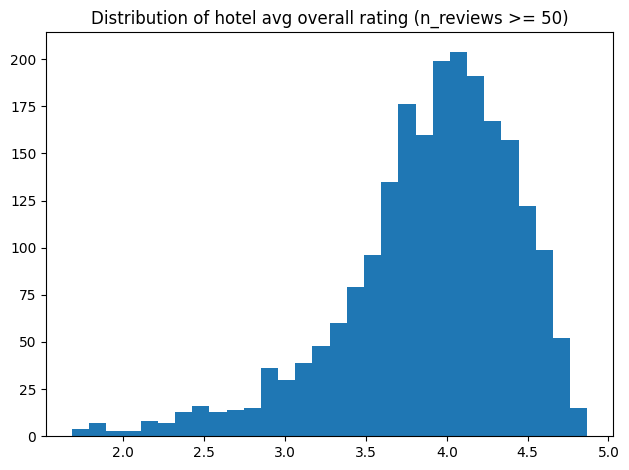

In [ ]:
plt.figure()
plt.hist(stable_hotels["avg_overall"], bins=30)
plt.title("Distribution of hotel avg overall rating (n_reviews >= 50)")
plt.tight_layout()
plt.show()

Across hotels with at least 50 reviews, average overall ratings are concentrated in the ~3.5–4.5 range, with a clear peak around the low-4s. There is a small left tail of poorly performing hotels (down to ~1.7–2.5), indicating a minority of properties with consistently weak guest experience.

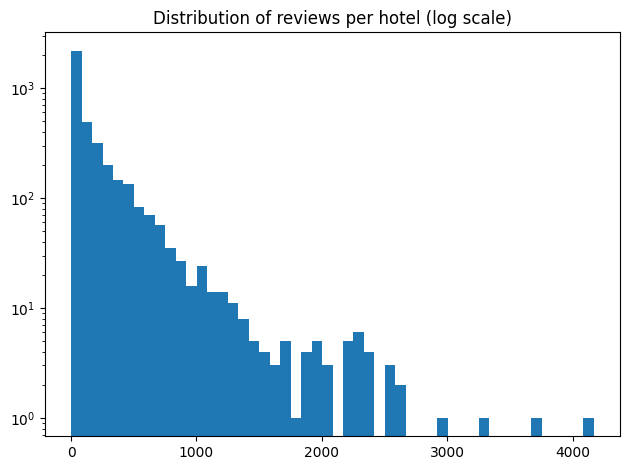

In [ ]:
plt.figure()
plt.hist(hotel_stats["n_reviews"], bins=50)
plt.yscale("log")
plt.title("Distribution of reviews per hotel (log scale)")
plt.tight_layout()
plt.show()

Review counts per hotel are highly right-skewed (long-tail): most hotels have relatively few reviews, while a small subset accumulates very large volumes (into the thousands). This supports using a minimum review threshold for fair benchmarking and also suggests that high-volume hotels will dominate aggregate trends if not segmented.

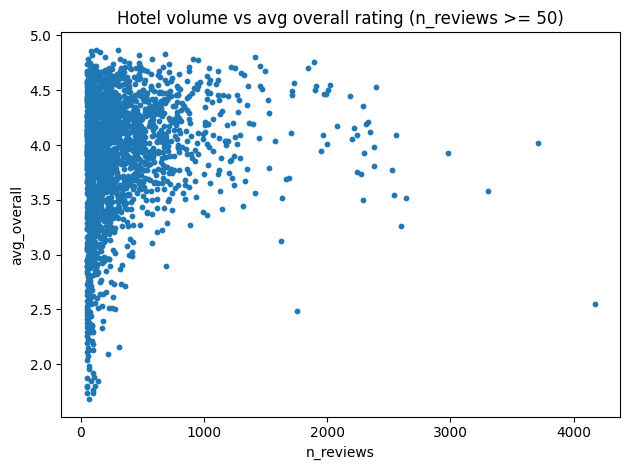

In [ ]:
plt.figure()
plt.scatter(stable_hotels["n_reviews"], stable_hotels["avg_overall"], s=10)
plt.title("Hotel volume vs avg overall rating (n_reviews >= 50)")
plt.xlabel("n_reviews")
plt.ylabel("avg_overall")
plt.tight_layout()
plt.show()

The scatter plot shows no strong positive relationship between review volume and average overall rating—high-volume hotels span a wide band of ratings rather than clustering at the top. The densest region is at lower review counts, where ratings are more dispersed (consistent with noisier estimates), while higher-volume hotels appear slightly more stable but still vary meaningfully in quality.

**Top / bottom hotels (use stability threshold)**

In [ ]:
top10 = stable_hotels.sort_values("avg_overall", ascending=False).head(10)
bottom10 = stable_hotels.sort_values("avg_overall").head(10)

top10, bottom10

(      offering_id  n_reviews  avg_overall  avg_service  avg_cleanliness  \
 3411      1175274        306         4.87         4.83             4.91   
 193         80092        129         4.87         4.90             4.96   
 3567      1465151         83         4.86         4.85             4.89   
 3823      2196840        160         4.85         4.88             4.93   
 3614      1516481        687         4.83         4.81             4.92   
 3851      2627745         90         4.82         4.90             4.91   
 3237       781627        472         4.82         4.83             4.93   
 3834      2322597        197         4.81         4.74             4.89   
 2682       258705       1414         4.80         4.84             4.90   
 283         80983        577         4.79         4.84             4.86   
 
       avg_value  avg_location  var_overall  
 3411       4.48          4.77         0.18  
 193        4.47          4.83         0.24  
 3567       4.82        

**Top performers**

The highest-rated hotels achieve avg_overall ≈ 4.79–4.87 with review volumes ranging roughly from ~80 to ~1,400+ reviews, indicating these are not “small-sample winners” only. Across these top hotels, cleanliness and service are consistently very high, while value is comparatively lower than cleanliness/service even among top performers—suggesting that “excellent stays” do not always translate into “excellent value-for-money.”

**Bottom performers**

The lowest-rated hotels have avg_overall ≈ 1.68–1.86 despite meeting the minimum review threshold (roughly ~50–144 reviews), implying persistent issues rather than isolated bad experiences. Their aspect ratings are uniformly low (service/cleanliness/value mostly near ~2), and several show very high variance, indicating inconsistent experiences and/or polarization among reviewers.

**Most “polarizing” hotels (highest variance)**

In [ ]:
polarizing = stable_hotels.sort_values("var_overall", ascending=False).head(10)
polarizing

,offering_id,n_reviews,avg_overall,avg_service,avg_cleanliness,avg_value,avg_location,var_overall
697,89357,60,2.72,3.02,2.83,3.09,3.23,3.30
1461,108260,56,2.96,3.21,3.11,3.02,3.31,2.75
1968,122584,100,3.29,3.64,3.32,3.49,3.61,2.65
2691,259218,50,2.48,2.73,2.48,3.00,4.09,2.57
1337,101653,357,2.71,2.93,2.82,2.83,3.17,2.55
1806,119608,81,3.04,3.45,3.25,3.50,3.74,2.48
635,88143,59,2.68,2.98,2.79,2.93,3.38,2.46
2155,220106,169,3.25,3.59,3.34,3.86,3.81,2.44
3103,623586,144,3.61,3.90,4.21,3.53,4.28,2.42
219,80244,204,2.66,3.13,2.67,3.06,3.82,2.41


A distinct set of hotels exhibits exceptionally high rating variance while maintaining moderate review counts e.g., ~50 to 357+ reviews.  These “polarizing” properties tend to have mid-to-low average overall ratings ~2.5 to 3.6 but extreme disagreement among guests, which is often a signal of inconsistent service delivery, mixed room quality, renovation phases, or expectation gaps e.g., location strong but operations weak. Notably, some polarizing hotels show high location ratings alongside low overall/service/cleanliness, suggesting that location alone is not enough to offset operational shortcomings and that guest experiences may differ widely depending on room type, staff interaction, or timing.

## Implications for subsequent analysis
Given the long-tail distribution of review volume, hotel comparisons should remain thresholded (e.g., n_reviews ≥ 50) and preferably allow filtering by volume tiers. The presence of very low-performing and high-variance (polarizing) hotels motivates dashboard features that highlight (i) consistent top/bottom performers and (ii) volatility flags, since high variance can represent operational inconsistency even when averages appear acceptable.

# Aspect analysis (from hotel_stats)

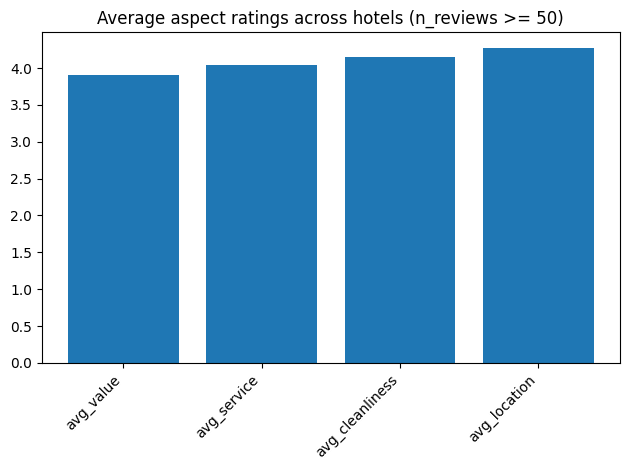

,0
avg_value,3.91
avg_service,4.05
avg_cleanliness,4.16
avg_location,4.27


In [ ]:
aspect_cols = ["avg_service","avg_cleanliness","avg_value","avg_location"]
aspect_means = stable_hotels[aspect_cols].mean().sort_values()

plt.figure()
plt.bar(aspect_means.index, aspect_means.values)
plt.title("Average aspect ratings across hotels (n_reviews >= 50)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

aspect_means

In [ ]:
corr = stable_hotels[["avg_overall"] + aspect_cols].corr(numeric_only=True)
corr["avg_overall"].sort_values(ascending=False)


,avg_overall
avg_overall,1.00
avg_cleanliness,0.96
avg_service,0.96
avg_value,0.90
avg_location,0.67


**Which aspect is weakest overall (mean across hotels)?**

Location is consistently the highest-rated aspect (mean ≈ 4.27), followed by cleanliness and service, whereas value has the lowest average score (mean ≈ 3.91). This suggests that while location is a baseline strength across hotels, improvements in cleanliness, service, and perceived value are more likely to translate into meaningful gains in overall guest satisfaction.
**Which aspects correlate most with overall?**

Correlation analysis shows that cleanliness and service are the strongest drivers of overall ratings, each exhibiting a very high correlation with average overall rating (ρ ≈ 0.96). Value also plays a significant role (ρ ≈ 0.90), while location—despite having the highest average score—shows a notably weaker relationship with overall satisfaction (ρ ≈ 0.67).


# Author behavior EDA

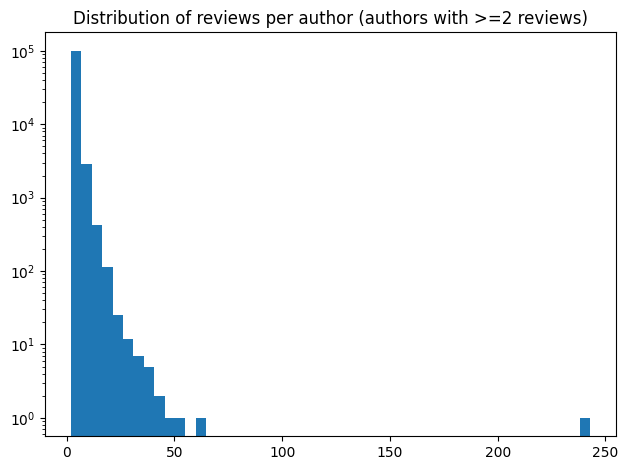

In [ ]:
plt.figure()
plt.hist(author_stats["n_reviews"], bins=50)
plt.yscale("log")
plt.title("Distribution of reviews per author (authors with >=2 reviews)")
plt.tight_layout()
plt.show()

The distribution of reviews per author is highly right-skewed, with the vast majority of authors contributing only a small number of reviews and a rapidly decreasing number of highly active reviewers. This long-tail pattern indicates that overall review content is dominated by occasional contributors, while a small subset of authors accounts for a disproportionate share of reviews.

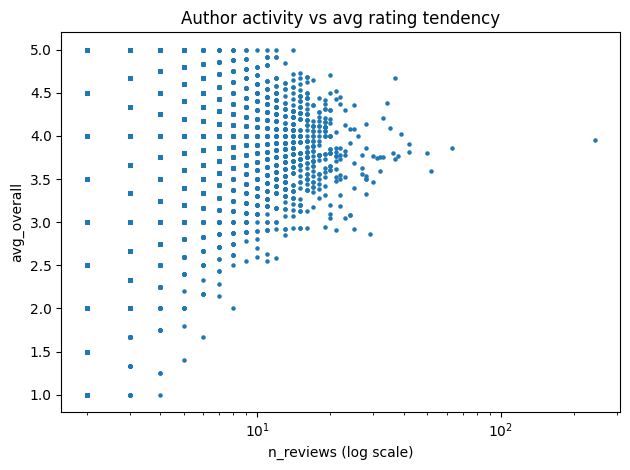

In [ ]:
plt.figure()
plt.scatter(author_stats["n_reviews"], author_stats["avg_overall"], s=5)
plt.xscale("log")
plt.title("Author activity vs avg rating tendency")
plt.xlabel("n_reviews (log scale)")
plt.ylabel("avg_overall")
plt.tight_layout()
plt.show()


The relationship between author activity and average rating shows **no strong systematic bias**, with most authors—regardless of activity level—clustered around average ratings of approximately 3.5–4.5. While less active authors exhibit greater variability in rating tendencies (likely due to small sample sizes), highly active authors appear more stable, suggesting their average ratings converge as contribution volume increases.

**Conclusion**

Overall, reviewer behavior is characterized by a long-tail contribution pattern with no clear evidence that highly active authors are systematically more lenient or more critical. This suggests that author-level bias is limited and that aggregating reviews across many authors provides a reasonably balanced representation of hotel performance, supporting the reliability of hotel-level benchmarking in subsequent analyses.

# Reviews EDA

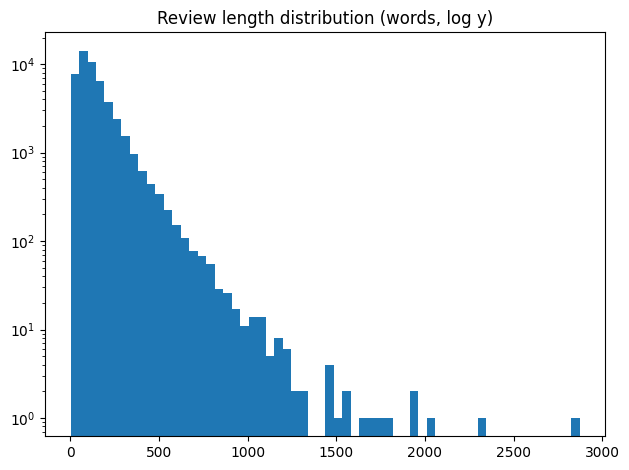

In [ ]:
plt.figure()
plt.hist(review_sample["len_words"], bins=60)
plt.yscale("log")
plt.title("Review length distribution (words, log y)")
plt.tight_layout()
plt.show()


Review lengths exhibit a highly right-skewed distribution, with most reviews being relatively short and a rapidly diminishing number of very long reviews extending beyond 1,000 words. The long tail suggests that while the majority of users provide brief feedback, a small subset of reviewers contribute detailed, narrative-style reviews, which may contain richer qualitative insights but should be treated carefully to avoid over-weighting verbose outliers in text analysis.

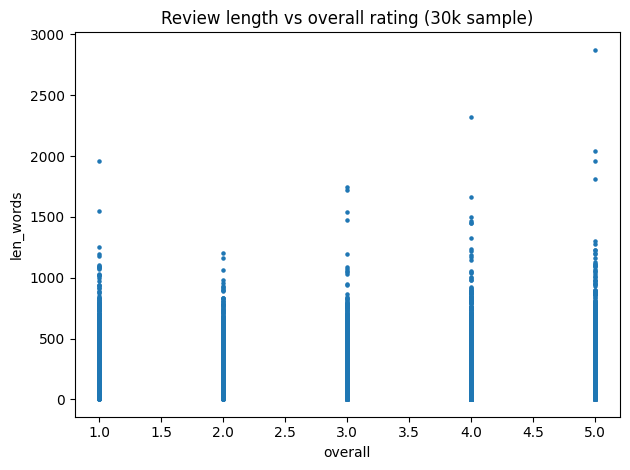

In [ ]:
plt.figure()
plt.scatter(review_sample["overall"], review_sample["len_words"], s=5)
plt.title("Review length vs overall rating (30k sample)")
plt.xlabel("overall")
plt.ylabel("len_words")
plt.tight_layout()
plt.show()


The relationship between review length and overall rating shows no strong linear correlation, with both short and long reviews appearing across all rating levels. However, lower ratings tend to exhibit greater variability in review length, including a higher concentration of very long reviews, suggesting that dissatisfied guests are more likely to provide detailed explanations. In contrast, higher ratings are more frequently associated with shorter reviews, indicating that positive experiences are often communicated more succinctly.

In [ ]:
mobile_stats = review_sample.groupby("via_mobile")["overall"].agg(["count","mean"])
mobile_stats


,count,mean
via_mobile,,
0,28107,3.99
1,1893,3.89


Non-mobile reviews account for the vast majority of submissions and are associated with a slightly higher average overall rating (≈ 3.99) compared to mobile reviews (≈ 3.89). Although the difference is modest, it suggests that mobile reviewers may be marginally more critical or more likely to submit reviews in response to negative experiences, a pattern commonly observed in user-generated content.

**Conclusion**

Textual review behavior is dominated by short reviews, with a small number of very long submissions contributing disproportionate text volume. Longer reviews are more common among lower-rated experiences, indicating that negative feedback tends to be more detailed, while positive feedback is often concise. Additionally, the slightly lower ratings observed in mobile-submitted reviews suggest that context and submission channel may influence both review sentiment and verbosity, which should be accounted for in subsequent text-based analyses.

# Final Findings
EDA reveals that service, cleanliness, and perceived value are the strongest drivers of overall hotel satisfaction, with value showing the greatest temporal volatility, while mobile reviews and longer texts are associated with dissatisfaction. These findings validate the use of stable review thresholds in benchmarking, inform dashboard KPI selection, and support further analytics such as sentiment detection and trend alerts in the production system.


## Insights

* Service quality is the primary performance lever.
Cleanliness and service are the strongest drivers of overall satisfaction, significantly outweighing location effects. Next step: prioritize service- and cleanliness-related KPIs in the dashboard and use them as leading indicators for performance improvement initiatives.

* Perceived value is the most volatile risk factor.
Value-for-money ratings fluctuate more over time and materially influence overall satisfaction. Next step: track value ratings alongside pricing or seasonal periods to identify when pricing strategies or guest expectations may be misaligned.

* Scale does not imply quality.
High-volume hotels span a wide range of ratings, and a small subset of hotels consistently underperform or exhibit high rating variance. Next step: enforce minimum review thresholds and flag low-performing or high-variance hotels for targeted operational review.

* Negative experiences drive disproportionate visibility.
Lower-rated reviews tend to be longer and more detailed, with mobile submissions slightly more critical, increasing reputational impact. Next step: monitor mobile review sentiment and review-length signals as early warnings of emerging service issues.

In [ ]:
# Close database connection
# It's good practice to close the database connection after all operations are completed
# to release resources and prevent potential locks or corruption.
conn.close()
print("Database connection closed")

Database connection closed
